In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    return np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)

In [3]:
def get_time_step(root, index):

    wse = txt_to_matrix(root + '/decoded--' + index + '.WSE')
    dep = txt_to_matrix(root + '/decoded--' + index + '.DEP')
    vvx = txt_to_matrix(root + '/decoded--' + index + '.VVX')
    vvy = txt_to_matrix(root + '/decoded--' + index + '.VVY')

    # timestep: matrice 801 rows x 4 misurazioni x 1256 colonne (valori)
    return np.array(list(zip(wse, dep, vvx, vvy)))

def get_dep_time_step(root, index):

    dep = txt_to_matrix(root + '/decoded--' + index + '.DEP')

    # timestep: matrice 801 rows x 4 misurazioni x 1256 colonne (valori)
    return np.array(dep)

In [4]:
rootdir = '../output/'
timesteps = []

paths = [p for p in sorted(os.listdir('../output'))]
x = 0
ceiling = 50

# Read all dirs and process them
for path in tqdm.tqdm(paths):
    
    if x >= ceiling: break
    
    # Processing
    path = rootdir + path
    timesteps.append(
        get_dep_time_step(
            path, ("{:04d}".format(x))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)

 94%|█████████▍| 50/53 [00:24<00:01,  2.07it/s]


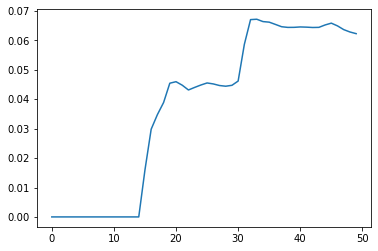

In [5]:
plt.plot(timesteps[:, 401, 600])

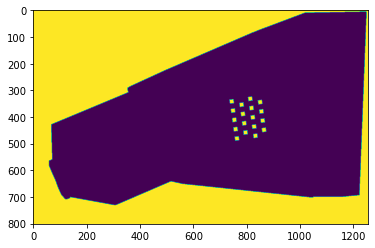

In [6]:
from skimage.transform import rescale, resize, downscale_local_mean

sample = timesteps[10, :, :]

ratio = 1
s_x = int(sample.shape[0] * ratio)
s_y = int(sample.shape[1] * ratio)

sample = resize(sample, (s_x, s_y))

plt.imshow(sample)

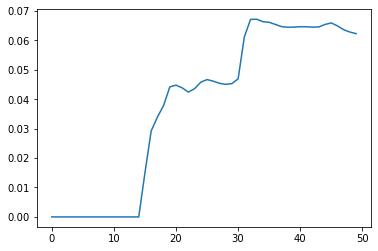

In [7]:
dataset = timesteps[:, :, :].astype(np.float64)

plt.plot(dataset[:, 400, 600])

In [8]:
'''
dataset_min = dataset.min(axis=(1, 2), keepdims=True)
dataset_max = dataset.max(axis=(1, 2), keepdims=True)
norm = ((dataset - dataset_min)/(dataset_max - dataset_min))

plt.plot(norm[:, 400, 600])
'''

dataset[dataset > 10] = 0

### Building the net

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [10]:
if torch.cuda.is_available():  
  dev = "cuda:0"
else:
  dev = "cpu"

device = torch.device(dev)

In [11]:
class CNNet(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self, w = 801, h = 1256):
        super(CNNet, self).__init__()
        
        # input channels, output channels
        self.conv1 = torch.nn.Conv2d(1, 5, 3)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # DNN
        self.fc1 = torch.nn.Linear(5 * 399 * 627, 64)
        self.fc2 = torch.nn.Linear(64, s_x * s_y)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        
        x = self.pool(x)
        
        x = x.flatten()
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return(x)

net = CNNet().to(device)

In [12]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = t-a-c  # free inside cache

print((f/t)*100)

86.07961491148363


/home/diego/anaconda3/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [13]:
import torch.optim as optim
from torchvision import transforms, utils

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training
# primo frame
in_x = dataset[0, :, :]

In [14]:
from copy import deepcopy

losses = []

for epoch in range(10):
    
    frame = 0
    
    epoch_loss = []
    for out_x in dataset[1:, :,:]:

        sample = torch.FloatTensor(resize(in_x, (s_x, s_y))).expand(1, 1, -1, -1).to(device)
        
        y = torch.FloatTensor(resize(out_x, (s_x, s_y))).flatten().to(device)
        
        #sample = torch.FloatTensor(in_x).to(device)
        #y = torch.FloatTensor(out_x).flatten().to(device)
            
        # Compute
        y_hat = net(
            sample
        ).to(device)
        
        # Loss
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())

        # Next step
        in_x = deepcopy(out_x)
        frame += 1
        
    avg = np.asarray(epoch_loss).mean()
    losses.append(avg)
    print("Epoch {} - avg.loss: {}".format(epoch, avg))

Epoch 0 - avg.loss: 0.0033039167328566617
Epoch 1 - avg.loss: 0.15670370399400743
Epoch 2 - avg.loss: 0.005633592016386742
Epoch 3 - avg.loss: 0.004287567412556738
Epoch 4 - avg.loss: 0.0037028838129600093
Epoch 5 - avg.loss: 0.0039201238791325265
Epoch 6 - avg.loss: 0.004349622922968499
Epoch 7 - avg.loss: 0.00478415188322566
Epoch 8 - avg.loss: 0.0053337237189466855
Epoch 9 - avg.loss: 0.005812844356559977


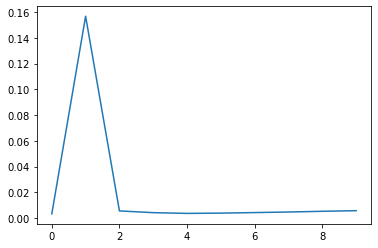

In [15]:
plt.plot(losses)